# Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import plotly.express as px
import plotly.figure_factory as ff
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

Seeding is important to ensure reproducibility

In [2]:
np.random.seed(0)

## Load Data
Load the data after the feature engineering step. We will be doing customer segmentation based on the train data only to prevent data leakage.

In [3]:
root = 'KuaiRec 2.0/'

joined_train_data = pd.read_csv(root + 'data_exports/joined_train_data_FE.csv')
joined_train_data.head()

,user_id,video_id,time,watch_ratio,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,fans_user_num,...,watch_frequency,is_weekend_interaction,is_weekend,time_period,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,avg_daily_watch_time,top_3_categories
0,14,148,2020-07-05 05:27:48.378,0.722103,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,8.360719e+12,"['Car', 'Pets', 'Real estate家居']"
1,14,183,2020-07-05 05:28:00.057,1.907377,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,8.360719e+12,"['Car', 'Pets', 'Real estate家居']"
2,14,3649,2020-07-05 05:29:09.479,2.063311,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,8.360719e+12,"['Car', 'Pets', 'Real estate家居']"
3,14,5262,2020-07-05 05:30:43.285,0.566388,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,8.360719e+12,"['Car', 'Pets', 'Real estate家居']"
4,14,8234,2020-07-05 05:35:43.459,0.418364,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,8.360719e+12,"['Car', 'Pets', 'Real estate家居']"


### Understanding unique categories
Due to the high dimensionality unique categories, we will only be selecting several relevant ones

{'total_entries': 1411, 'unique_categories': 35, 'category_distribution':                                          count  percentage
Political news updates                     987       23.32
Car                                        653       15.43
Military                                   461       10.89
Gym锻炼                                      299        7.06
Three Rurals                               220        5.20
Sports                                     184        4.35
UNKNOWN                                    180        4.25
Game                                       160        3.78
Strange phenomena                          140        3.31
TV and Film Reviews/Collections            112        2.65
Fashion                                    103        2.43
Humanities                                  95        2.24
Reading                                     91        2.15
Real estate家居                               89        2.10
Education                                

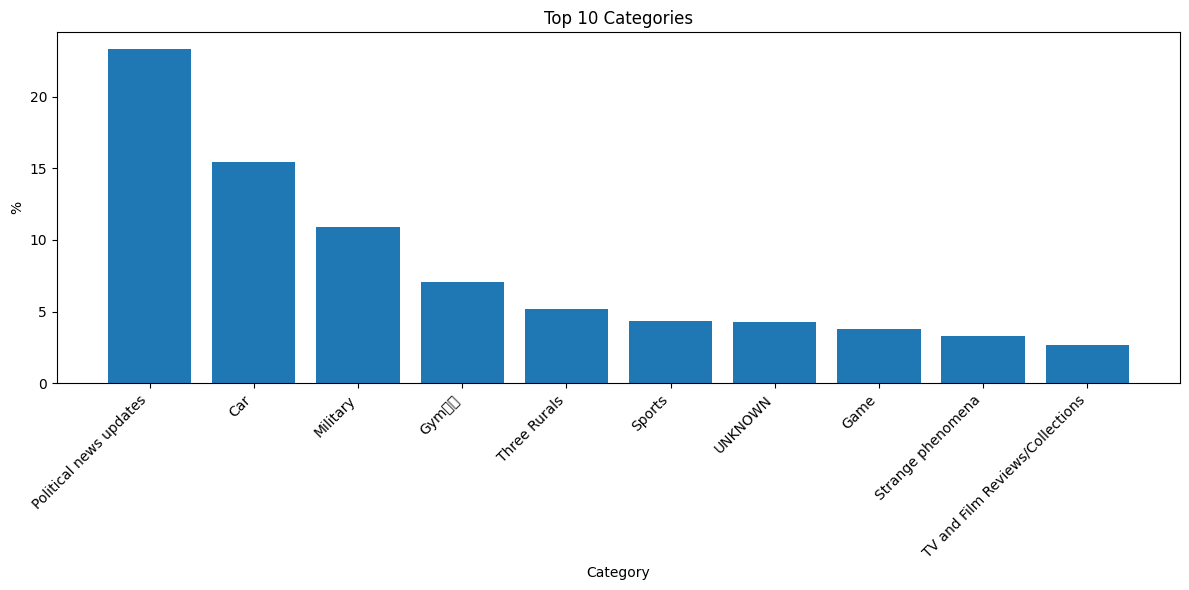

In [4]:
from collections import Counter
import ast

def analyze_categories(df, category_column='top_3_categories'):
    def parse_list(x):
        try:
            return ast.literal_eval(x) if isinstance(x, str) else x
        except:
            return []
    
    df[category_column] = df[category_column].apply(parse_list)
    all_categories = [cat for sublist in df[category_column] if isinstance(sublist, list) for cat in sublist]
    category_counts = Counter(all_categories)
    category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    category_df['percentage'] = (category_df['count'] / len(all_categories) * 100).round(2)
    
    return {
        'total_entries': len(df),
        'unique_categories': len(set(all_categories)),
        'category_distribution': category_df
    }

def plot_category_distribution(df, category_column='top_3_categories', top_n=10):
    import matplotlib.pyplot as plt
    analysis = analyze_categories(df, category_column)
    top_categories = analysis['category_distribution'].head(top_n)
    
    plt.figure(figsize=(12, 6))
    plt.bar(top_categories.index, top_categories['percentage'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top_n} Categories')
    plt.xlabel('Category')
    plt.ylabel('%')
    plt.tight_layout()
    plt.show()

df_unique = joined_train_data.drop_duplicates(subset=['user_id'], keep='first')
res = analyze_categories(df_unique, category_column='top_3_categories')
print(res)
plot_category_distribution(df_unique, category_column='top_3_categories', top_n=10)

Select the features that we want, and how each of these features may be useful for video recommendations & user segmentation. <br><br>

Numerical features:
- follow_user_num: indicates user engagement level and social connectivity within the platform, helping identify passive consumers versus active community members
- is_new_user: distinguishes between new and established users, capturing differences in platform familiarity and usage patterns based on their user lifecycles
- watch_frequency: reveal the user's consumption habits and platform stickiness, differentiating between casual viewers and power users
- is_weekend: identify temporal usage preferences, helping identify users who watches daily as part of their lives, or only during weekends on their free time
- count_afternoon_views: captures viewing patterns during traditional working/school hours, indicating potential student or professional status and lifestyle patterns
- count_evening_views: shows prime-time consumption habits, helping identify users who follow traditional entertainment consumption patterns
- count_midnight_views: indicates night-time viewing behavior, useful for identifying night owls
- count_morning_views: shows early-day engagement patterns, early birds, helping identify users who integrate the platform into their morning routines
- avg_daily_watch_time: quantifies overall platform engagement intensity, distinguishing between brief browsers and deeply engaged users

<br>

For categorical features, we will be grouping them into respective mappings if they have high values of overlap (e.g., political news, public information) <br>
Categorical Features:
- News & Politics (~40%)
- Automotive & Tech (~16%)
- Lifestyle & Fashion (~15%)
- Sports & Fitness (~12%)
- Entertainment & Media (~10%)
- Culture & Education (~7%)

In [5]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Select all numerical columns
    num_cols = ['follow_user_num', 'is_new_user', 'watch_frequency', 
                'is_weekend', 'count_afternoon_views', 'count_evening_views',
                'count_midnight_views', 'count_morning_views']
    
    # Select only unique users
    df_unique = df.drop_duplicates(subset=['user_id'], keep='first')
    
    category_mapping = {
        # News & Politics (~40%)
        'Political news updates': 'News_Politics',
        'Public information on livelihood issues': 'News_Politics',
        'Military': 'News_Politics',
        'Science and Law': 'News_Politics',
        'Finance': 'News_Politics',
        'Three Rurals': 'News_Politics',
        'Three rurals': 'News_Politics',
        
        # Automotive & Tech (~16%)
        'Car': 'Auto_Tech',
        'HighTech Digital': 'Auto_Tech',
        
        # Lifestyle & Fashion (~15%)
        'Fashion': 'Lifestyle',
        'Life': 'Lifestyle',
        'Real estate家居': 'Lifestyle',
        'Beauty index': 'Lifestyle',
        'Makeup': 'Lifestyle',
        'Selfie': 'Lifestyle',
        
        # Sports & Fitness (~12%)
        'Sports': 'Sports_Fitness',
        'Gym锻炼': 'Sports_Fitness',
        
        # Entertainment & Media (~10%)
        'TV and Film Reviews/Collections': 'Entertainment',
        'Game': 'Entertainment',
        'Music': 'Entertainment',
        'Dance': 'Entertainment',
        "Stars' Entertainment": 'Entertainment',
        'Two-dimensional': 'Entertainment',
        
        # Culture & Education (~7%)
        'Education': 'Culture',
        'Reading': 'Culture',
        'Humanities': 'Culture',
        'Art': 'Culture',
        'Photography': 'Culture',
    }
    
    # List conversion
    def convert_to_list(x):
        if isinstance(x, list):
            return x
        if isinstance(x, str):
            try:
                x = x.strip()
                if x.startswith('[') and x.endswith(']'):
                    return eval(x)
                else:
                    return [x] if x else []
            except:
                return []
        return []
    
    # Category mapping
    def map_category(x):
        categories = convert_to_list(x)
        mapped_cats = set()
        for cat in categories:
            if cat is not None and cat in category_mapping:
                mapped_cats.add(category_mapping[cat])
        return list(mapped_cats)

    # Define known category
    def is_others(x):
        categories = convert_to_list(x)
        if not categories:  # empty list
            return 1
        if 'UNKNOWN' in categories:
            return 1
        return 1 if any(cat not in category_mapping for cat in categories if cat is not None) else 0

    # Create binary columns for each major category
    major_categories = set(category_mapping.values())
    for category in major_categories:
        df_unique[category] = df_unique['top_3_categories'].apply(
            lambda x: 1 if category in map_category(x) else 0
        )
    
    df_unique['Others'] = df_unique['top_3_categories'].apply(is_others)
    
    # Combine numerical columns with new category columns
    category_cols = list(major_categories) + ['Others']
    final_cols = num_cols + category_cols
    
    return df_unique[final_cols]

In [6]:
user_ids = joined_train_data['user_id'].unique()
processed_data = preprocess_data(joined_train_data)
processed_data.head()

,follow_user_num,is_new_user,watch_frequency,is_weekend,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,Lifestyle,Sports_Fitness,Auto_Tech,News_Politics,Entertainment,Culture,Others
0,73,0,57.966667,0.283496,118,493,824,304,1,0,1,0,0,0,1
1739,3,0,63.633333,0.295966,1051,15,0,843,0,0,1,1,0,0,0
3648,63,0,63.366667,0.324040,631,227,331,712,0,0,0,1,0,0,1
5549,94,0,61.900000,0.262251,841,277,36,703,0,1,0,1,0,0,1
7406,59,0,62.266667,0.288009,727,338,209,594,0,0,0,0,0,1,1


## Principal Component Analysis
PCA (Principal Component Analysis) serves as a crucial preprocessing step before clustering for several reasons. First, it reduces the dimensionality of our feature space while preserving the most important patterns in the data, making clustering more computationally efficient. Importantly, PCA helps address the "curse of dimensionality" where distances between points become less meaningful in high-dimensional spaces, which is also taught in lecture. <br><br>

We will be performing PCA to 3 components, which is sufficiently low-dimension and makes visualization easier too

In [7]:
def perform_pca(df: pd.DataFrame) -> Tuple[pd.DataFrame, PCA]:
    # standardize the features first
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    
    # apply PCA with 3 components
    pca = PCA(n_components=3, random_state=0)
    pca_result = pca.fit_transform(data_scaled)
    
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=['PC1', 'PC2', 'PC3']
    )
    
    return pca_df, pca

pca_df, pca = perform_pca(processed_data)
print("Explained variance ratio:", pca.explained_variance_ratio_)
pca_df.head()

Explained variance ratio: [0.12965141 0.10418915 0.09054447]


,PC1,PC2,PC3
0,0.972788,-0.809663,1.867439
1,-1.724345,0.589349,-1.940992
2,-0.669153,0.586888,0.379931
3,-1.562102,0.303086,-0.310811
4,-1.538039,0.754815,2.411610


### Elbow plot
The elbow plot can serve as a decent gauge for how many clusters we should segment the users into.

  File "c:\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


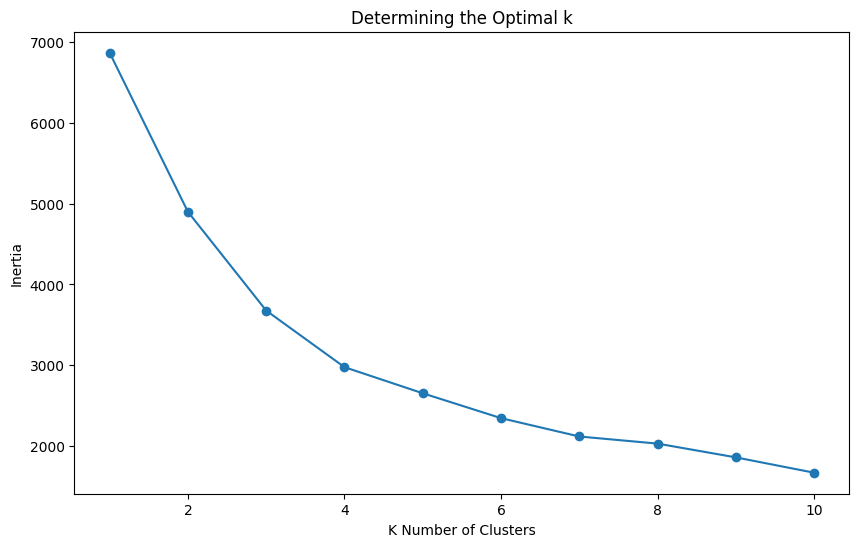

In [8]:
def plot_elbow_method(pca_df: pd.DataFrame, max_clusters: int = 10) -> int:
    inertias = []
    
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(pca_df)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Determining the Optimal k')
    plt.show()
    
    return

plot_elbow_method(pca_df)

As we can see here, there is a sharp decrease in gradient after 4 clusters, to a more smooth and linear gradient. Hence, we will be selecting 4 different clusters for K means clustering

## K-Means Clustering
We will be performing K-Means clustering on the components that we have derived

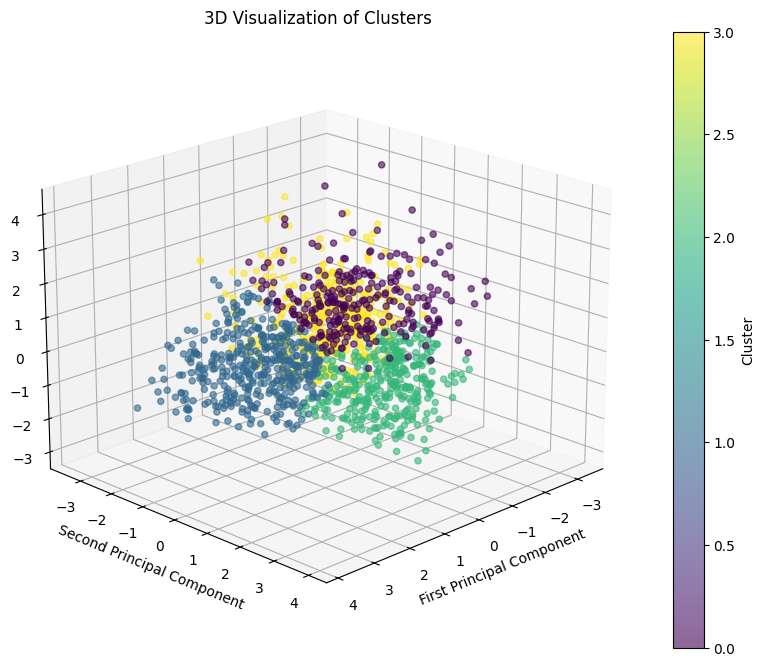

In [9]:
def perform_clustering(pca_df: pd.DataFrame, n_clusters: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_df)
    return clusters

def plot_3d_clusters(pca_df: pd.DataFrame, clusters: np.ndarray):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot
    scatter = ax.scatter(pca_df['PC1'], 
                        pca_df['PC2'], 
                        pca_df['PC3'],
                        c=clusters, 
                        cmap='viridis',
                        alpha=0.6)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    ax.set_title('3D Visualization of Clusters')
    plt.colorbar(scatter, label='Cluster')
    
    # Adjust the viewing angle to visualize more easily
    ax.view_init(elev=20, azim=45)
    
    plt.show()

clusters = perform_clustering(pca_df, n_clusters=4)
plot_3d_clusters(pca_df, clusters)

This shows the clusters in their 3D components after performing PCA

In [10]:
user_cluster_mapping = pd.DataFrame({
        'user_id': user_ids,
        'cluster': clusters
    })

processed_data['user_id'] = joined_train_data.loc[processed_data.index, 'user_id']  # Add user_id back
new_columns = ['user_id', 'cluster', 'News_Politics', 'Auto_Tech', 'Lifestyle', 'Sports_Fitness', 'Entertainment', 'Culture', 'Others']
df_cluster = processed_data.merge(user_cluster_mapping, on='user_id', how='left')
final_df = joined_train_data.merge(df_cluster[new_columns], on='user_id', how='left')

# Save the final dataset
final_df.to_csv(root + 'data_exports/joined_train_data_segmented.csv', index=False)

## Analysis of Clusters

In this section, we want to identify how each user group is segmented based on the different features we have chosen at the start, which helps us gain insights into how we can potentially tailor our recommendation strategies in real life.

### Distribution of Cluster Counts

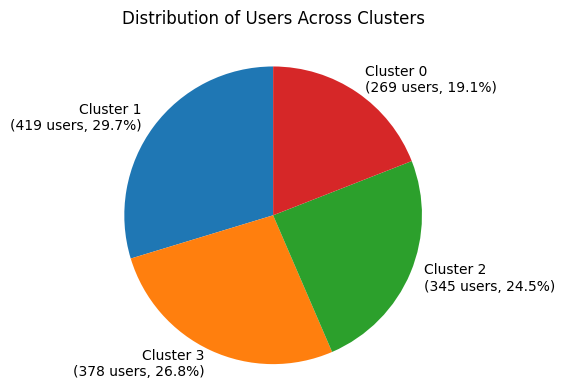

In [11]:
import warnings 
warnings.filterwarnings('ignore')

users = final_df.drop_duplicates(subset=['user_id'], keep='first')
cluster_counts = users['cluster'].value_counts()

# Plot cluster distributions
plt.figure(figsize=(5, 4))
plt.pie(cluster_counts.values, 
        labels=[f'Cluster {i}\n({v:,} users, {(v/len(users)*100):.1f}%)' 
                for i, v in cluster_counts.items()],
        autopct='',
        startangle=90)
plt.title('Distribution of Users Across Clusters', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

### is_new_user (binary)

<Figure size 1200x600 with 0 Axes>

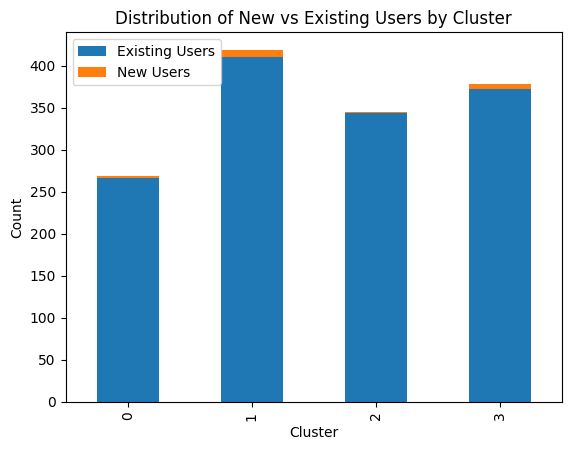

Percentage of new users in each cluster:
cluster
0    0.74
1    2.15
2    0.29
3    1.59
Name: is_new_user, dtype: float64


In [12]:
plt.figure(figsize=(12, 6))
users.groupby(['cluster', 'is_new_user']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of New vs Existing Users by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(['Existing Users', 'New Users'])
plt.show()

new_user_pct = users.groupby('cluster')['is_new_user'].mean() * 100
print("Percentage of new users in each cluster:")
print(new_user_pct.round(2))

As we can see here, cluster 1, & 3 has low new user counts.
On the other hand, cluster 0 and 2 has relatively higher presence of new users

### follow_user_num

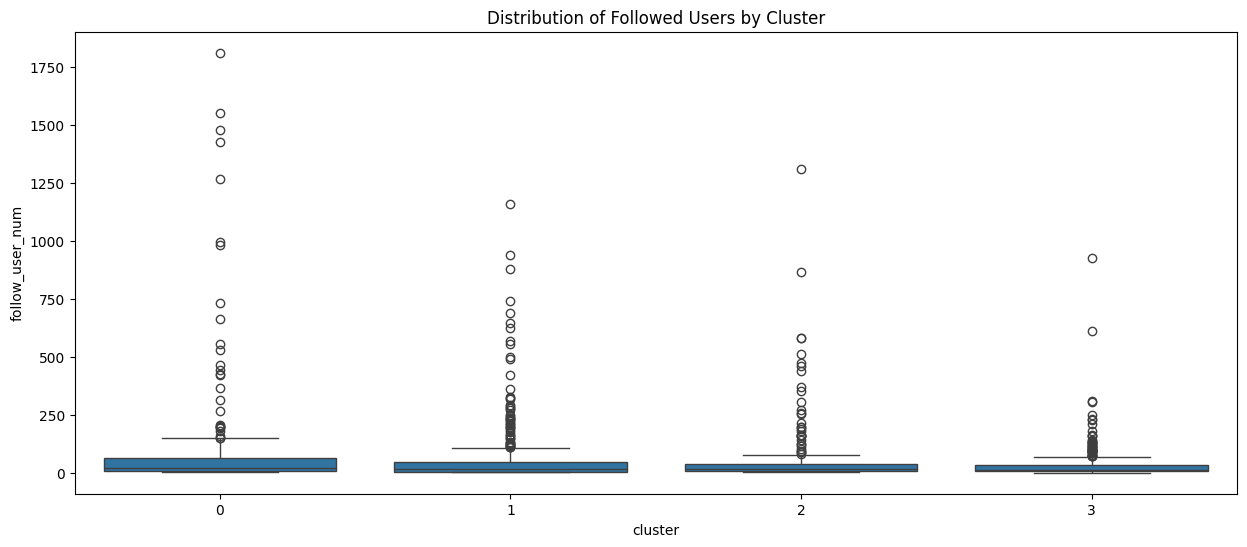

Follower statistics by cluster:
         count   mean     std  min  25%   50%   75%     max
cluster                                                    
0        269.0  88.70  234.73  1.0  9.0  21.0  65.0  1811.0
1        419.0  56.71  128.83  1.0  5.0  14.0  46.0  1157.0
2        345.0  46.58  114.43  1.0  8.0  15.0  36.0  1311.0
3        378.0  33.28   69.77  0.0  7.0  13.0  32.0   927.0


In [13]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=users, x='cluster', y='follow_user_num')
plt.title('Distribution of Followed Users by Cluster')
plt.show()

print("Follower statistics by cluster:")
print(users.groupby('cluster')['follow_user_num'].describe().round(2))

Here, we can see that cluster 3 generally have a higher follower counts, which may suggest higher user activity/video posting. <br>
Clusters 0, 1 & especially 2 has lower average follower counts, suggesting lower user activity.

### watch_frequency
This is the average number of videos watched per day per user

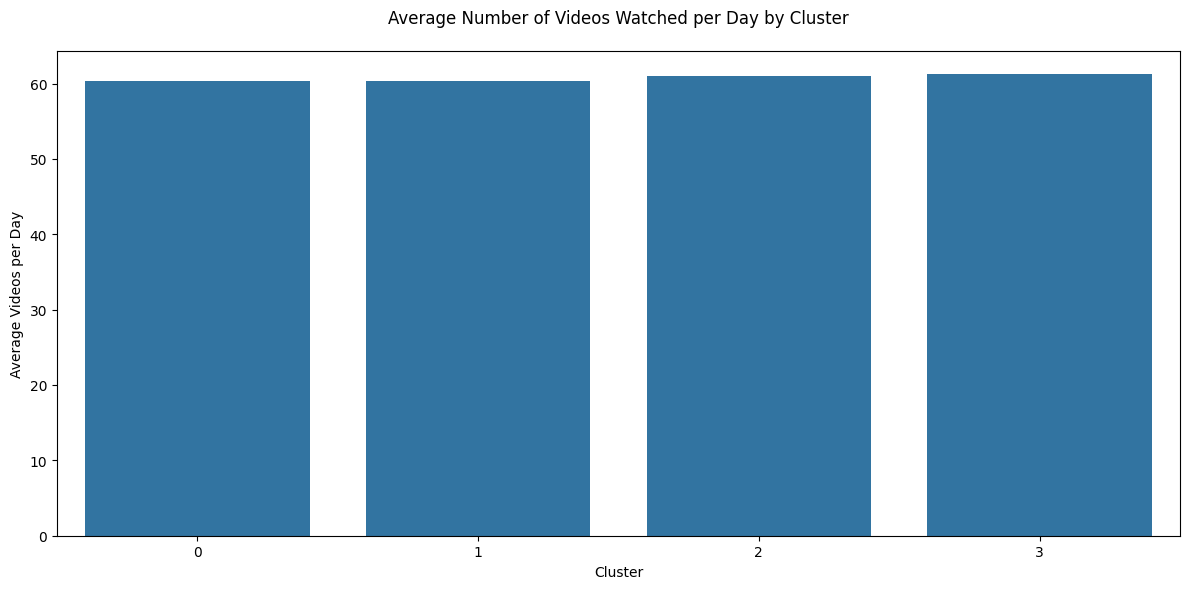

Watch frequency statistics by cluster:
         count   mean   std    min    25%    50%    75%     max
cluster                                                        
0        269.0  60.33  3.76  47.77  58.00  60.47  62.50   77.96
1        419.0  60.29  3.85  43.90  58.23  60.53  62.60   75.87
2        345.0  61.03  3.82  49.67  58.70  60.97  63.07   88.55
3        378.0  61.28  5.22  50.10  58.54  61.28  63.40  107.56


In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(data=users, x='cluster', y='watch_frequency', estimator=np.mean, ci=None)
plt.title('Average Number of Videos Watched per Day by Cluster', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Average Videos per Day')
plt.tight_layout()
plt.show()

print("Watch frequency statistics by cluster:")
print(users.groupby('cluster')['watch_frequency'].describe().round(2))

Watch frequency is pretty even across all the groups.

### Viewing Time Patterns
This section analyses count_morning_views, count_afternoon_views, count_evening_views and count_midnight_views for clusters

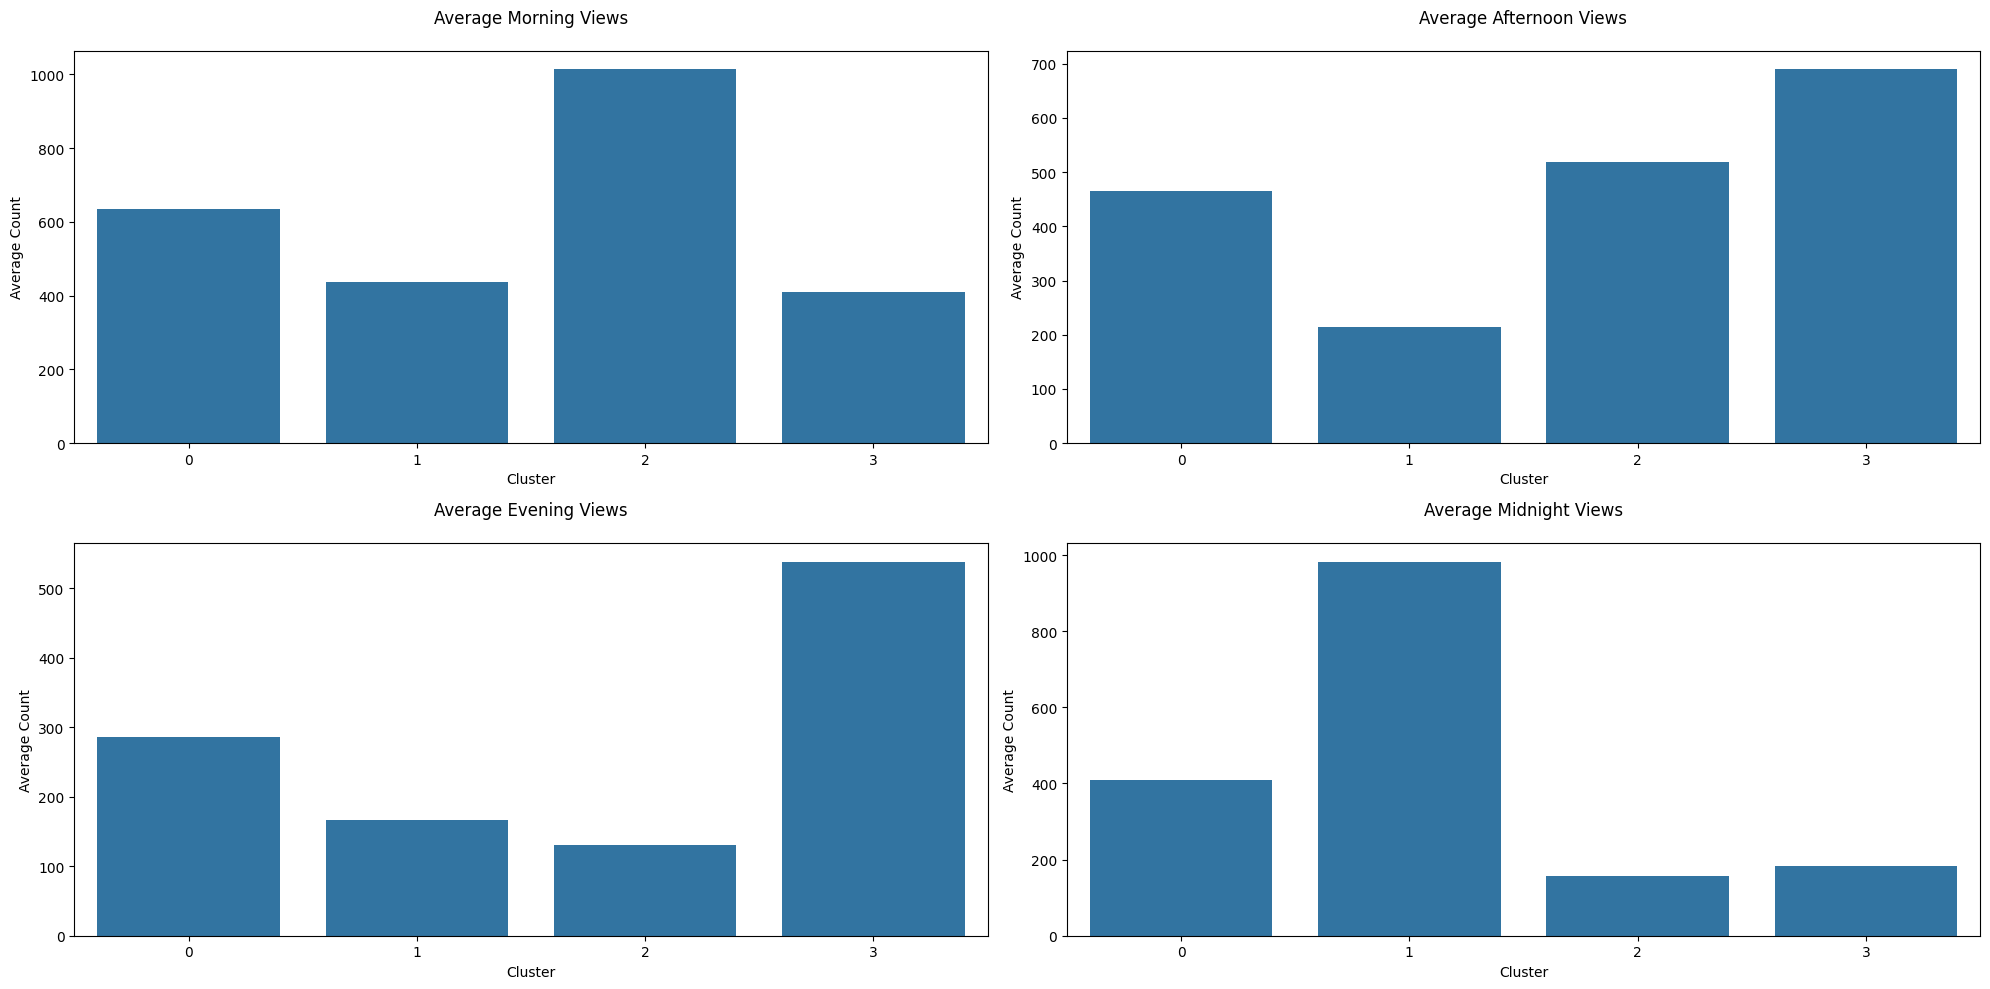

In [15]:
viewing_patterns = ['count_morning_views', 'count_afternoon_views', 
                   'count_evening_views', 'count_midnight_views']

# Create separate bar plots for each viewing pattern
plt.figure(figsize=(20, 10))
for idx, pattern in enumerate(viewing_patterns, 1):
    plt.subplot(2, 2, idx)
    sns.barplot(data=users, x='cluster', y=pattern, estimator=np.mean, ci=None)
    plt.title(f'Average {pattern.replace("count_", "").replace("_", " ").title()}', pad=20)
    plt.xlabel('Cluster')
    plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

This analysis is quite insightful, as it shows that:
- Cluster 0 prefers watching in the midnight
- Cluster 1 prefers watching in the morning & afternoon
- Cluster 2 prefers watching in the afternoon & evening
- Cluster 3 watches very evenly at all times

### Weekend vs Weekday

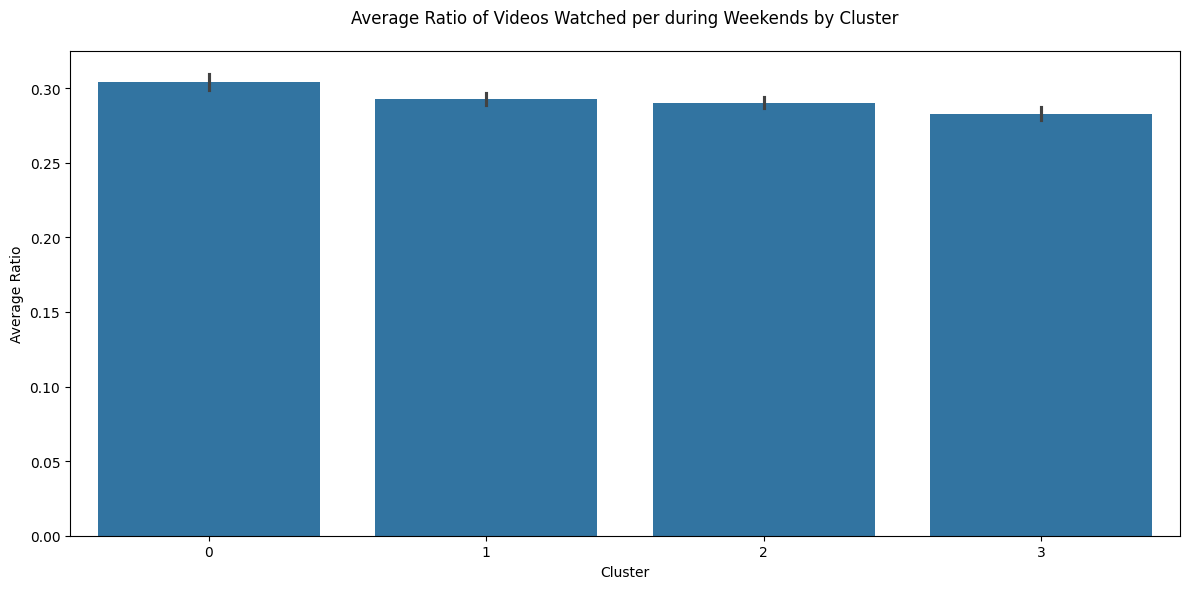

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=users, x='cluster', y='is_weekend', estimator=np.mean)
plt.title('Average Ratio of Videos Watched per during Weekends by Cluster', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Average Ratio')
plt.tight_layout()
plt.show()

This chart is pretty even-looking across the clusters

### Category Analysis

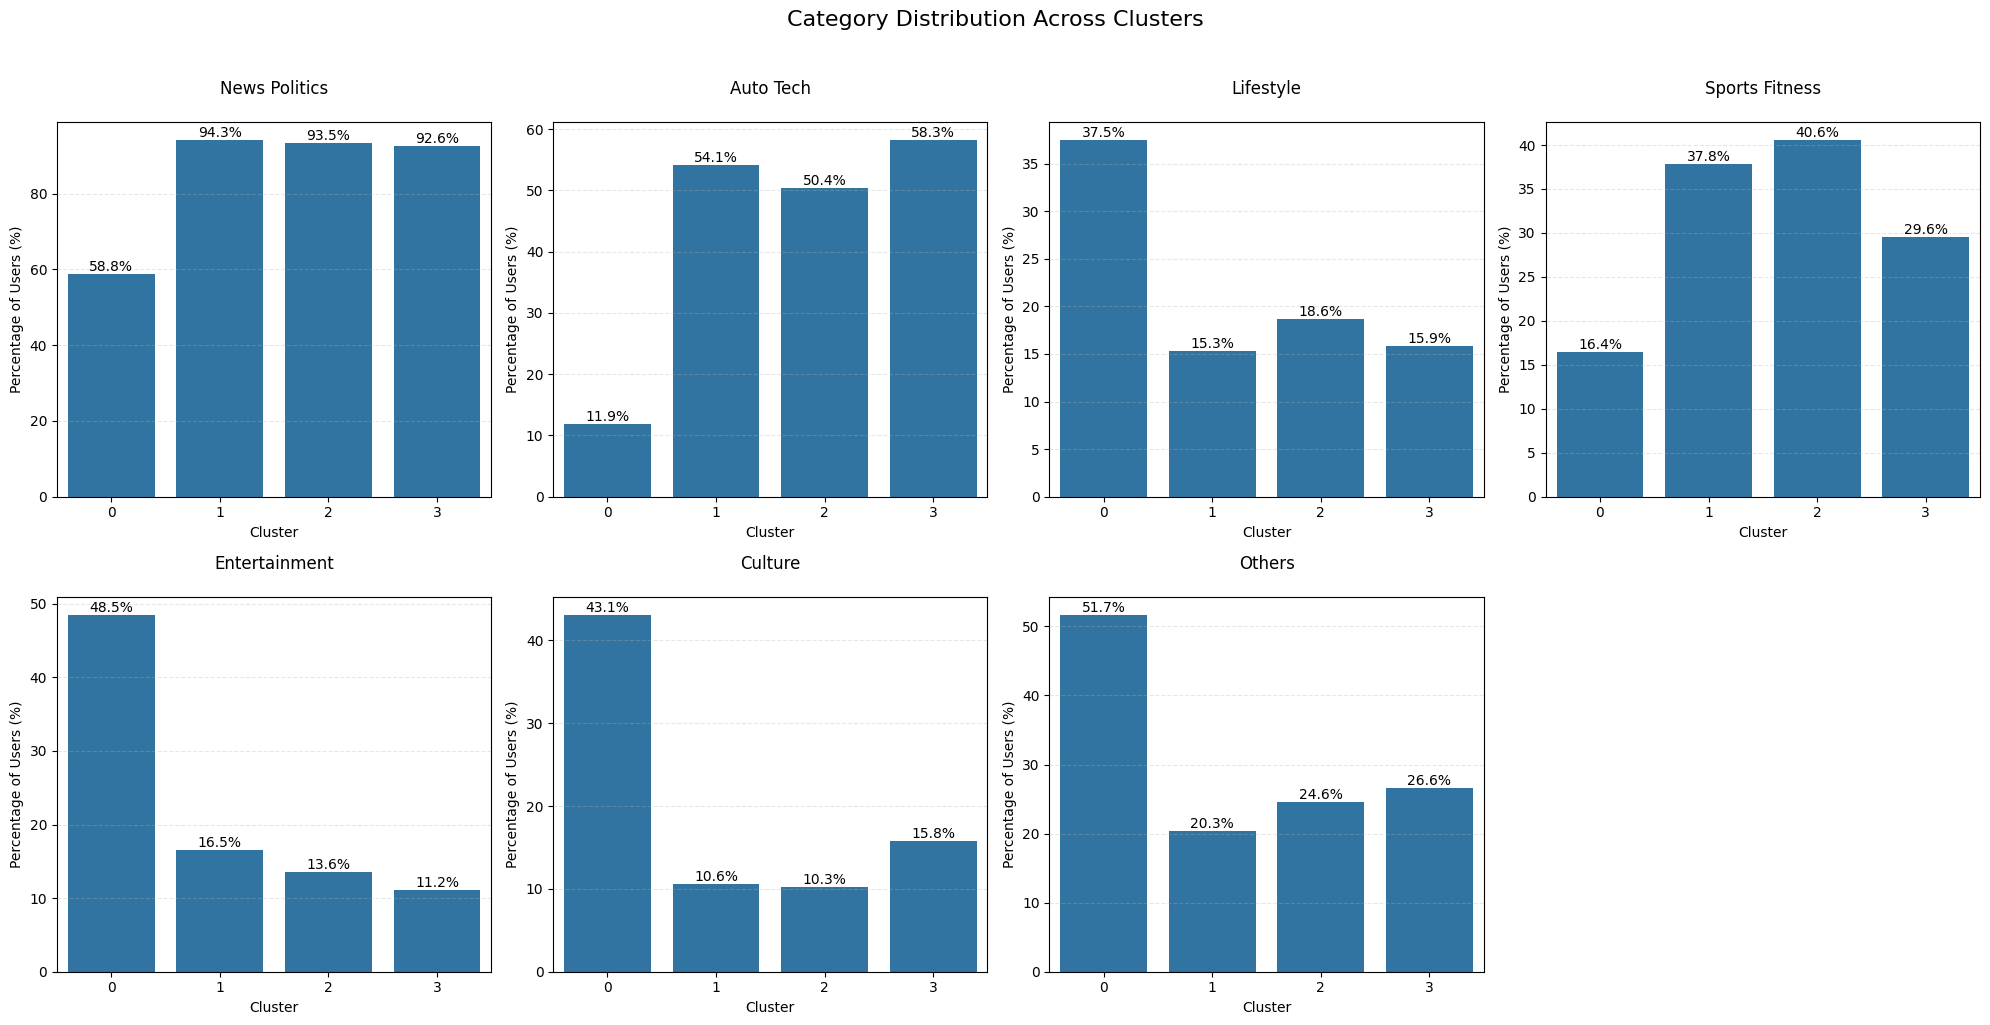

In [17]:
category_cols = ['News_Politics', 'Auto_Tech', 'Lifestyle', 
               'Sports_Fitness', 'Entertainment', 'Culture', 'Others']

plt.figure(figsize=(20, 10))
for idx, category in enumerate(category_cols, 1):
   plt.subplot(2, 4, idx)
   sns.barplot(data=final_df, x='cluster', y=category, estimator=lambda x: np.mean(x)*100, ci=None)
   plt.title(f'{category.replace("_", " ")}', pad=20)
   plt.xlabel('Cluster')
   plt.ylabel('Percentage of Users (%)')
   
   for p in plt.gca().patches:
       plt.text(p.get_x() + p.get_width()/2.,
               p.get_height(),
               f'{p.get_height():.1f}%',
               ha='center',
               va='bottom')
       
   plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle('Category Distribution Across Clusters', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

As we can see here, there are a lot of insights can be derived for the preferences of each cluster:
- Cluster 0: These users are heavily invested in News & Politics (94.30%) and have significant interest in Auto & Tech (54.39%). They also maintain solid engagement with Sports & Fitness (37.53%).
- Cluster 1: Also very similar to cluster 0, they show strong interest in News & Politics (93.60%) and Auto & Tech (50.29%), with Sports & Fitness (40.41%) as their third-highest interest.
- Cluster 2: Theyalso  strongly favor News & Politics (92.63%) and have the highest interest in Auto & Tech (58.16%). Sports & Fitness (30.00%) is their third highest interest, but lower than the other 2 clusters.
- Cluster 3: While News & Politics (58.27%) still leads for this cluster, they show significantly higher interest in Entertainment (48.50%), Culture (42.86%), and Lifestyle (38.35%) compared to other clusters.

### Final Summary Statistics

In [18]:
summary_stats = pd.DataFrame()
for cluster in users['cluster'].unique():
    cluster_data = users[users['cluster'] == cluster]
    
    summary_stats[f'Cluster_{cluster}'] = pd.Series({
        'count': len(cluster_data),
        'pct_new_users': cluster_data['is_new_user'].mean() * 100,
        'avg_follow': cluster_data['follow_user_num'].mean(),
        'avg_videos_per_day': cluster_data['watch_frequency'].mean(),
        'pct_weekend': cluster_data['is_weekend'].mean() * 100,
        'avg_morning': cluster_data['count_morning_views'].mean(),
        'avg_afternoon': cluster_data['count_afternoon_views'].mean(),
        'avg_evening': cluster_data['count_evening_views'].mean(),
        'avg_midnight': cluster_data['count_midnight_views'].mean(),
        'News & Politics': cluster_data['News_Politics'].mean() * 100,
        'Auto & Tech': cluster_data['Auto_Tech'].mean() * 100,
        'Lifestyle': cluster_data['Lifestyle'].mean() * 100,
        'Sports & Fitness': cluster_data['Sports_Fitness'].mean() * 100,
        'Entertainment': cluster_data['Entertainment'].mean() * 100,
        'Culture': cluster_data['Culture'].mean() * 100,
        'Others': cluster_data['Others'].mean() * 100
    })
print("Cluster Summary Statistics:")
print(summary_stats.round(2))

Cluster Summary Statistics:
                    Cluster_0  Cluster_2  Cluster_1  Cluster_3
count                  269.00     345.00     419.00     378.00
pct_new_users            0.74       0.29       2.15       1.59
avg_follow              88.70      46.58      56.71      33.28
avg_videos_per_day      60.33      61.03      60.29      61.28
pct_weekend             30.41      29.02      29.30      28.28
avg_morning            634.61    1013.59     436.64     408.88
avg_afternoon          465.40     518.97     214.17     689.14
avg_evening            286.49     129.81     166.07     537.73
avg_midnight           410.22     156.09     981.98     183.48
News & Politics         58.74      93.62      94.27      92.59
Auto & Tech             11.90      50.43      54.42      58.47
Lifestyle               37.92      18.84      15.27      15.87
Sports & Fitness        16.36      40.58      37.71      29.63
Entertainment           48.70      13.62      16.47      11.11
Culture                 42.

## Customer Segmentation

### Cluster 0 - Night Owl, Sports Enthusiasts
Key Features (421 users): 
- Highest percentage of new users (2.14%)
- Strong midnight viewing preference (980.62)
- Highest consumption of News & Politics (94.30%)
- Moderate interest in Auto & Tech (54.39%)
- Balanced viewing across other categories
- Moderate number of follows (56.57)
- Likely to belong to night owls, people who have 'poorer' sleeping hygiene


### Cluster 1 - Office Hour Multi-Category Viewers
Key Features (344  users): 
- Strong morning viewing preference (1017.02)
- High engagement with News & Politics (93.60%)
- Second-highest interest in Auto & Tech (50.29%)
- Notable interest in Sports & Fitness (40.41%)
- Moderate follow count (46.38)
- Low evening/midnight viewing
- Likely to have occupations where they are able to browse excessively during office hours, such as students or night-shift workers


### Cluster 2 - Afternoon-Evening Tech Enthusiasts
- Peak viewing in afternoon (692.24) and evening (533.95)
- Strong interest in News & Politics (92.63%)
- Highest interest in Auto & Tech (58.16%)
- Lowest engagement with Entertainment (10.79%)
- Lowest average follows (33.67)
- Likely to belong to office workers, following patterns of watching videos after work, and with more focus on news and less on entertainment


### Cluster 3 - Balanced Content Explorers
- Most balanced viewing across time periods
- Highest number of follows (89.14)
- Most diverse content consumption:
    - Lowest News & Politics consumption (58.27%)
    - Highest Entertainment (48.50%)
    - Highest Culture (42.86%)
    - Highest Lifestyle (38.35%)
    - Highest Others (51.88%)



### General Trends
1. News & Politics are dominant across all clusters, most notably a relatively lower presence for Cluster 3
2. Each cluster has distinct temporal viewing patterns
3. Cluster_3 shows the most diverse content preferences
4. Video consumption per day is relatively consistent (~60-61 videos)
5. Weekend viewing percentage is similar across clusters (~28-30%)